# Practical 3

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cvxopt  # needed later on
import pandas as pd
import sklearn as sk

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
% cd gdrive/MyDrive/ml_2021

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/ml_2021


# Task 0: Preliminaries

This time we will work with a synthetic 2d dataset to facilitate visualization and be able to focus on the algorithms rather than spending energy to understand the dataset. The dataset consists of two classes and two predictors. Below we load the dataset and plot it.

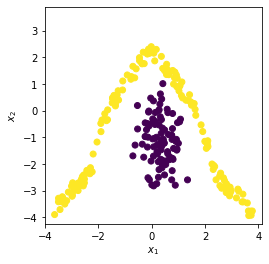

In [3]:
X_2d, t_2d = np.load('data/nonlin_2d_data.npy')[:, :2], np.load('data/nonlin_2d_data.npy')[:, 2]

plt.scatter(X_2d[:, 0], X_2d[:, 1], c=t_2d)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('square');

### Task 0.1

Apply logistic regression and LDA to the provided data, compute classification accuracy and plot the predictions. How do they perform? You're welcome to use sklearn for this task.

In [4]:
# Split data in training and test set
def split_data(X, y, frac=0.3, seed=None):
    if seed is not None:
        np.random.seed(seed)

    ### implement the function here
    shuffle_ids = np.array(range(len(y)))
    np.random.shuffle(shuffle_ids)

    slice_ind = int((1-frac) * len(y))

    X = pd.DataFrame(X)

    X = pd.DataFrame.reset_index((X.loc[shuffle_ids,:]), 
                                 drop = True)
    y = y[shuffle_ids]

    X_train = X.loc[:slice_ind-1,]
    y_train = y[:slice_ind]

    X_test = X.loc[slice_ind:,]
    y_test = y[slice_ind:]


    return np.array(X_train), np.array(X_test), y_train, y_test

In [5]:
def accuracy(y_true, y_pred):
  n_c = np.sum((y_true == y_pred)) #number of correctly classified
  acc = n_c/len(y_true)
  return acc

In [6]:
X_train, X_test, t_train, t_test = split_data(X_2d, t_2d, seed = 2912)

###Logistic Regression

In [7]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
lreg = LogisticRegression().fit(X_train, t_train)

In [8]:
y_train_lreg = lreg.predict(X_train)
y_test_lreg = lreg.predict(X_test)

print("The accuracy on the training set is ", accuracy(t_train, y_train_lreg), " and on the test set ", accuracy(t_test, y_test_lreg))

The accuracy on the training set is  0.5885714285714285  and on the test set  0.5333333333333333


###LDA

In [9]:
#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
sklda = LinearDiscriminantAnalysis()

sklda = sklda.fit(X_train, t_train)

In [10]:
y_train_lda = sklda.predict(X_train)
y_test_lda = sklda.predict(X_test)

print("The accuracy on the training set is ", accuracy(t_train, y_train_lda), " and on the test set ", accuracy(t_test, y_test_lda))

The accuracy on the training set is  0.5885714285714285  and on the test set  0.52


###Plots to compare

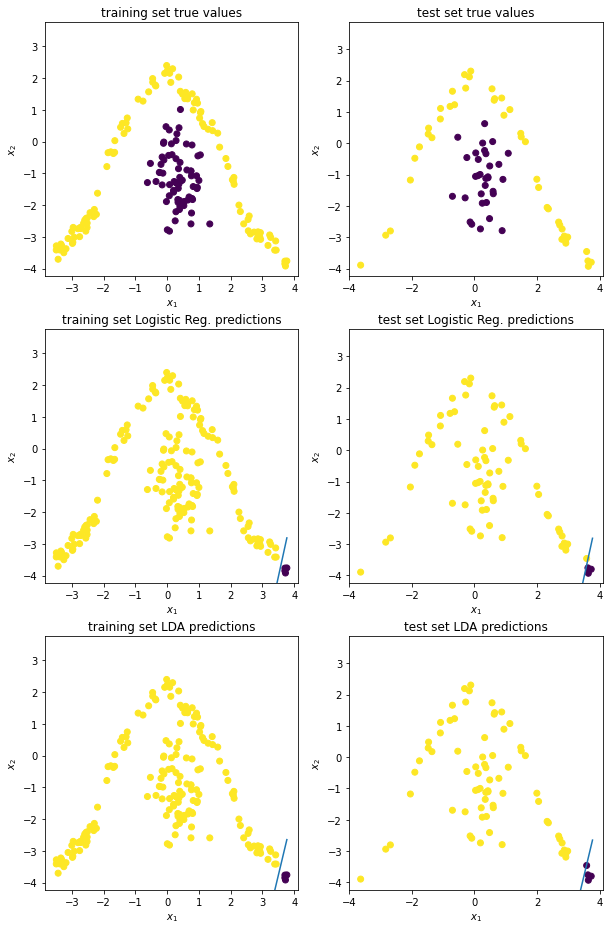

In [11]:
plt.figure(figsize=(10,16))

plt.subplot(3,2,1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=t_train)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('square')   
plt.title('training set true values')

plt.subplot(3,2,2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=t_test)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('square')   
plt.title('test set true values')


#Plots Logistic Regression
#decision boundary
x1 = np.array([np.min(X_train[:,0], axis=0), np.max(X_train[:,0], axis=0)])
b, w1, w2 = lreg.intercept_, lreg.coef_[0][0], lreg.coef_[0][1]
y1 = -(b+x1*w1)/w2 

plt.subplot(3,2,3)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train_lreg)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('square')   
plt.plot(x1,y1)
plt.title('training set Logistic Reg. predictions')

plt.subplot(3,2,4)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test_lreg)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('square')   
plt.plot(x1,y1)
plt.title('test set Logistic Reg. predictions')


#Plots LDA
#decision boundary
x1 = np.array([np.min(X_train[:,0], axis=0), np.max(X_train[:,0], axis=0)])
b, w1, w2 = sklda.intercept_, sklda.coef_[0][0], sklda.coef_[0][1]
y1 = -(b+x1*w1)/w2 

plt.subplot(3,2,5)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train_lda)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('square')   
plt.plot(x1,y1)
plt.title('training set LDA predictions')

plt.subplot(3,2,6)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test_lda)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('square')   
plt.plot(x1,y1)
plt.title('test set LDA predictions')
plt.show()

### Task 0.2

Implement the Gaussian RBF and visualize the pairwise similarities of `x`.

In [12]:
x = np.stack([np.sin(np.linspace(0, 8, 15)), np.cos(np.linspace(0, 7, 15))]).T

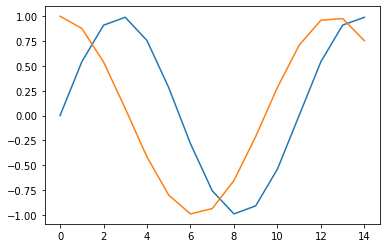

In [13]:
plt.plot(x)
plt.show()

In [14]:
# RBF kernel
def grbf(x1, x2):
  tmp = np.square(x1 - x2)
  tmp = -(1/2) * np.sum(tmp)
  return np.exp(tmp)

In [15]:
# Visualize pairwise similarities
res = np.zeros(len(x)*len(x))


#loop over all pairs in x and compute rbf Kernel
for i, xi in enumerate(x):
  for j, xj in enumerate(x):
    res[i*len(x) + j] = grbf(xi, xj)

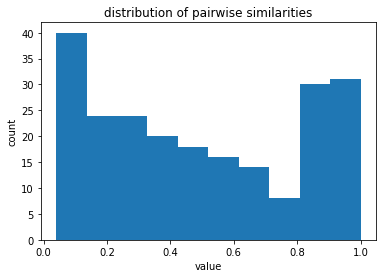

In [16]:
plt.hist(res)
plt.xlabel('value')
plt.ylabel('count')
plt.title('distribution of pairwise similarities')
plt.show()

# Task 1: Kernel Discriminant Analysis

We will be implementing Kernel Discriminant Analysis, a nonlinear extension to LDA based on the kernel trick, following the original paper by Mika, Rätsch, Weston, Schölkopf and Müller (PDF on StudIP). Note, this is the original notation from the paper, mind the difference betweeen the matrix $M$ and the vectors $M_1, M_2$.

The goal of Kernel Discriminant Analysis is find a vector of $\alpha$'s that maximizes
$$ J(\alpha) = \frac{\alpha^T M \alpha}{\alpha^T N \alpha} $$
where
$$M := (M_1 - M_2)(M_1 - M_2)^T \text{ with } (M_i)_j = \frac{1}{l_i} \sum_{k=1}^{l_i} k(x_j, x_k^i)$$ and
$$N= \sum_{j=1,2} K_j (I - 1_{l_j}) K_j^T$$
Here, the number of samples for class $j$ is denoted by $l_j$. In the definition of $N$, $(K_{j})_{n,m} = k(x_n, x_m^j)$, $I$ is the identity matrix and $1_{l_j}$ is a matrix with each entry equal to $1/l_j$. $M_1, M_2$ have shape $(l_0 + l_1)$ each, $N$ and $M$ have shape $(l_0 + l_1) \times (l_0 + l_1)$.

We obtain the optimal solution by $\alpha = N^{-1}(M_1 - M_0)$. Note that you may have to regularize $N^{-1}$ for numerical stability (see paper or Wikipedia).

Prediction for an arbitrary sample $x$ is then carried out by building a weighted sum over it's kernel with the samples from the training set.

1. Implement a function `kda(X, t, kernel)` that carries out Kernel Discriminant Analysis on the data $X,t$ and returns a vector `alpha`.
2. Implement a function `def predict(x, X, alpha, kernel)`.
3. Visualize results given a linear kernel and a Gaussian Radial Basis Function kernel.

Use the following snippet as a starting point.

In [17]:
def kda(X, t, kernel):
    l = [(t == 0).sum(), (t == 1).sum()]
    X_split = X[(t == 0)], X[(t == 1)]
    M = np.ones((2, len(X)))

    #fill M vectors
    for i in range(len(l)):
      for j in range(len(X)):
        M[i][j] = 0

        for k in range(l[i]):
          M[i][j] += (1/l[i]) * kernel(X[j], X_split[i][k])

    #get M matrix
    tmp = M[0] - M[1]
    Mmat = np.matmul(tmp, tmp.T)
    
    #fill K Matrix
    K = np.ones((len(X), l[0])), np.ones((len(X), l[1]))
    for i in range(len(l)):
      for j in range(K[i].shape[0]):
        for k in range(K[i].shape[1]):
          K[i][j, k] = kernel(X[j], X_split[i][k])

    #N matrix
    N = np.zeros((len(X), len(X)))
    for i in range(len(l)):
      tmp = np.identity(l[i]) - 1/l[i] * np.ones((l[i], l[i]))
      tmp = np.matmul(tmp, K[i].T)
      N += np.matmul(K[i], tmp)

    #final calculation: alpha = N^-1 % (M1 - M0)
    Ninv = np.linalg.inv(N)
    Ms = M[1] - M[0]
    alpha = np.matmul(Ninv, Ms)

    thresh = 0
    for i in range(len(alpha)):
      thresh += alpha[i] * ( 0.5 * (M[1][i] + M[0][i]) )

    return alpha, thresh  


def predict(x, X, alpha, thresh, kernel):
    y = []
    xlen = x.shape[0]
    for j in range(xlen):
        r = 0
        for i in range(len(alpha)):
            r +=  alpha[i] * kernel(X[i], x[j])
        y.append(r)
    y = np.array(y)
    return (y > thresh)


def linear_kernel(x_n, x_m):
    return np.matmul(x_n, x_m.T)

def rbf_kernel(x_n, x_m, gamma=4):
    tmp = np.square(x_n - x_m)
    tmp = -(1/gamma) * np.sum(tmp)
    return np.exp(tmp)

In [18]:
# Perform KDA with linear and RBF kernel
alpha_rbf, thresh_rbf = kda(X_train, t_train, rbf_kernel)
alpha_lk, thresh_lk = kda(X_train, t_train, linear_kernel)

In [20]:
preds_train = predict(X_train, X_train, alpha_rbf, thresh_rbf, rbf_kernel)
preds_test = predict(X_test, X_train, alpha_rbf, thresh_rbf, rbf_kernel)
print("For the RBF kernel, accuracy is", accuracy(t_train, preds_train), "on the training set and", accuracy(t_test, preds_test), "on the test set")

For the RBF kernel, accuracy is 1.0 on the training set and 1.0 on the test set


In [21]:
preds_train = predict(X_train, X_train, alpha_lk, thresh_lk, linear_kernel)
preds_test = predict(X_test, X_train, alpha_lk, thresh_lk, linear_kernel)
print("For the linear kernel, accuracy is", accuracy(t_train, preds_train), "on the training set and", accuracy(t_test, preds_test), "on the test set")

For the linear kernel, accuracy is 0.44571428571428573 on the training set and 0.38666666666666666 on the test set


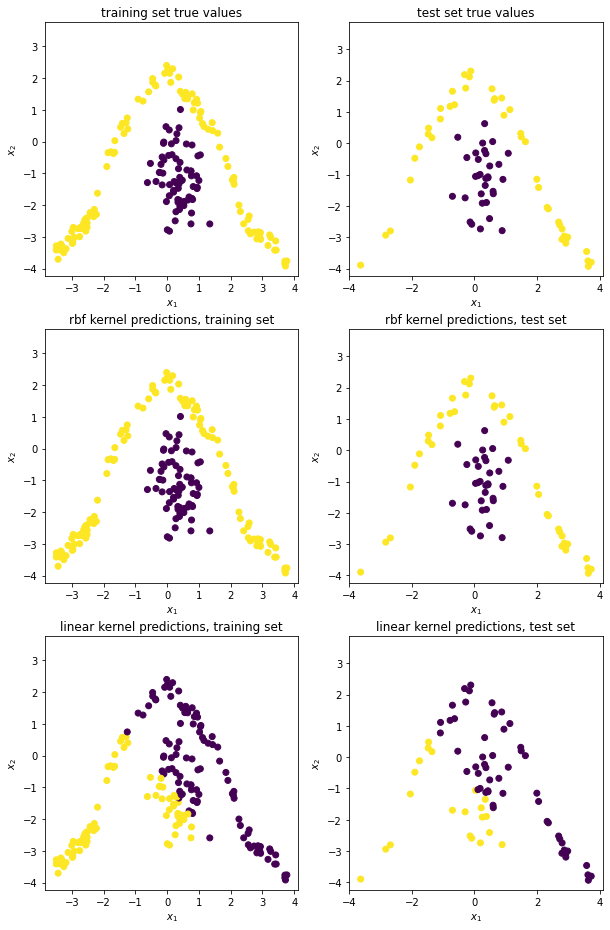

In [24]:
# Visualize results
plt.figure(figsize=(10,16))

plt.subplot(3,2,1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=t_train)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('square')   
plt.title('training set true values')

plt.subplot(3,2,2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=t_test)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('square')   
plt.title('test set true values')

plt.subplot(3,2,3)
preds = predict(X_train, X_train, alpha_rbf, thresh_rbf, rbf_kernel)
plt.scatter(X_train[:, 0], X_train[:, 1], c=preds)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('square') 
plt.title('rbf kernel predictions, training set') 

plt.subplot(3,2,4)
preds = predict(X_test, X_train, alpha_rbf, thresh_rbf, rbf_kernel)
plt.scatter(X_test[:, 0], X_test[:, 1], c=preds)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('square') 
plt.title('rbf kernel predictions, test set') 


plt.subplot(3,2,5)
preds = predict(X_train, X_train, alpha_lk, thresh_lk, linear_kernel)
plt.scatter(X_train[:, 0], X_train[:, 1], c=preds)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('square') 
plt.title('linear kernel predictions, training set') 


plt.subplot(3,2,6)
preds = predict(X_test, X_train, alpha_lk, thresh_lk, linear_kernel)
plt.scatter(X_test[:, 0], X_test[:, 1], c=preds)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('square') 
plt.title('linear kernel predictions, test set') 

plt.show() 

We can see that the RBF kernel performs a lot better than the linear kernel. In fact, the linear kernel performs even worse than LDA and Logistic Regression.

### Task 1.2

Which value would you use as a threshold to separate the classes? Use this threshold value to visualize the decision boundaries in a 2d grid (see example code below) and make predictions on the test set.

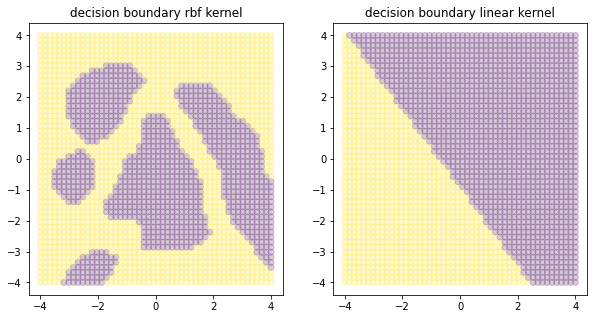

In [23]:
def plot_decision_boundary(predict_fn):
    ''' Plot decision boundary.

    predict_fn: function handle to a predict function that takes
                as input a data point x and outputs the predicted
                label t
    '''
    grid = np.meshgrid(np.linspace(-4, 4, 50), np.linspace(-4, 4, 50))
    grid_x, grid_y = grid[0].flatten(), grid[1].flatten()

    grid_t = np.zeros(len(grid_x))
    for i, p in enumerate(zip(grid_x, grid_y)):
      tmp = np.array(p)
      tmp = np.reshape(tmp, (1, 2))
      grid_t[i] = predict_fn(tmp)

    plt.scatter(grid_x, grid_y, c=grid_t, alpha=0.2)


plt.figure(figsize = (10, 5))
plt.subplot(1,2, 1)
predict_fn = lambda x: predict(x, X_train, alpha_rbf, thresh_rbf, rbf_kernel)
plot_decision_boundary(predict_fn)
plt.title('decision boundary rbf kernel')

plt.subplot(1, 2, 2)
predict_fn = lambda x: predict(x, X_train, alpha_lk, thresh_lk, linear_kernel)
plot_decision_boundary(predict_fn)
plt.title('decision boundary linear kernel')
plt.show()


We can see that while the RBF manages to perfectly capture the data we see in the sample, it extrapolates perhaps somewhat unexpectedly towards areas where there is not a lot of data, so we would have to be careful there.